In [2]:
import sys
import gzip
import matplotlib.pyplot as plt
import numpy as np
import cooler
import pandas as pd
import cooltools

Merge the pairs files, keep only the "important" chromosomes and only one header

In [3]:

def filter_pairs_by_specific_chromosomes(input_file, output_file):
    # List of chromosomes to filter
    target_chromosomes = ["2L_JJg14_439","2R_JJg14_439", "3L_JJg14_439", "3R_JJg14_439", "4_JJg14_439", "X_JJg14_439", "Y_JJg14_439", "2L_JJg14_057", "2R_JJg14_057", "3L_JJg14_057", "3R_JJg14_057", "4_JJg14_057", "X_JJg14_057", "Y_JJg14_057"]
    buffer = []
    
    buffer_size = 10000

    with gzip.open(input_file, 'rt') as infile, gzip.open(output_file, 'at') as outfile:
        for line in infile:
            #keep only one header and append the other 2 files without the header
            if line.startswith("#") and input_file == "/data/alhajabed/FlyHiC/PoreC/20250625_balancedMcools/24L004895_PnM1.pairs.gz":  # Process header lines
                # Check if the header line starts with any of the target chromosomes
                if line.startswith("#chromsize"):
                    parts = line.strip().split(" ")
                    if parts[1] in target_chromosomes:
                        #create a new chromosome trans and add it to the header
                        buffer.append(line)
                elif line.startswith("#samheader: @SQ"):
                    parts = line.strip().split(":")
                    parts2 = parts[2].strip().split("LN")
                    if parts2[0].strip() in target_chromosomes:
                        buffer.append(line)
                else:
                    buffer.append(line)

                outfile.writelines(buffer)
                buffer=[]
                continue
            elif line.startswith("#"):
                continue
            parts = line.strip().split("\t")
            # Check if both parts[1] and parts[3] are in the target chromosomes list
            if parts[1] in target_chromosomes and parts[3] in target_chromosomes:

                buffer.append(line)
      
                if len(buffer) >= buffer_size:
                    outfile.writelines(buffer)
                    buffer=[]

        
        
input_file1 = "/data/alhajabed/FlyHiC/PoreC/20250625_balancedMcools/24L004895_PnM1.pairs.gz"
input_file2 = "/data/alhajabed/FlyHiC/PoreC/20250625_balancedMcools/24L004896_PnM2.pairs.gz"
input_file3 = "/data/alhajabed/FlyHiC/PoreC/20250625_balancedMcools/24L004897_PnM3.pairs.gz"
output = "/data/alhajabed/FlyHiC/PoreC/20250625_balancedMcools/20250727_merged_PnMs.filt.pairs.gz"

  
filter_pairs_by_specific_chromosomes(input_file1, output)
filter_pairs_by_specific_chromosomes(input_file2, output)
filter_pairs_by_specific_chromosomes(input_file3, output)


Pairs too cooler:

(PoreC) erikson@deep22:/data/alhajabed/FlyHiC/PoreC/20250625_balancedMcools$ cooler cload pairs -c1 2 -p1 3 -c2 4 -p2 5 /data/alhajabed/FlyHiC/PoreC/20250625_balancedMcools/diploid_genome.importantChroms.chromsizes:1000 20250727_merged_PnMs.filt.pairs.gz 20250727_merged_PnMs.filt.pairs.cool

"scalings can be calculated from raw, unbalanced coolers"

Reading in the pairs file again and converting the chromosomes to 2R or 2R_trans etc

In [6]:
def filter_pairs_by_specific_chromosomes(input_file, output_file):
    # List of chromosomes to filter
    buffer = []
    
    buffer_size = 10000

    with gzip.open(input_file, 'rt') as infile, gzip.open(output_file, 'wt') as outfile:
        for line in infile:
            if line.startswith("#"):  # Process header lines
                # Check if the header line starts with any of the target chromosomes
                if line.startswith("#chromsize"):
                    parts = line.strip().split(" ")
                    #create a new chromosome trans and add it to the header
                    line = line.replace("_JJg14_057", "_trans")
                    line = line.replace("_JJg14_439", "_trans")
                    buffer.append(line)
                    #and then replace trans with nothing and add the sis chromosomes to header
                    line = line.replace("_trans", "")
                    buffer.append(line)
                    continue
                elif line.startswith("#samheader: @SQ"):
                    parts = line.strip().split(":")
                    parts2 = parts[2].strip().split("LN")
                    line = line.replace("_JJg14_057", "_trans")
                    line = line.replace("_JJg14_439", "_trans")
                    buffer.append(line)
                    line = line.replace("_trans", "")
                    buffer.append(line)
                    continue
                else:
                    buffer.append(line)
                    continue

            parts = line.strip().split("\t")
                
            if parts[1] == parts[3]:
                line = line.replace("_JJg14_057", "")
                line = line.replace("_JJg14_439", "")
            else:
                line = line.replace("_JJg14_057", "_trans")
                line = line.replace("_JJg14_439", "_trans")
            
            buffer.append(line)
    
            if len(buffer) >= buffer_size:
                outfile.writelines(buffer)
                buffer=[]

        outfile.writelines(buffer)


        
        
input_file = "/data/alhajabed/FlyHiC/PoreC/20250625_balancedMcools/20250727_merged_PnMs.filt.pairs.gz"
output_file = "/data/alhajabed/FlyHiC/PoreC/20250625_balancedMcools/20250729_merged_PnMs.filtCisTrans.pairs.gz"

  
filter_pairs_by_specific_chromosomes(input_file, output_file)


Pairs to cool:

(PoreC) erikson@deep22:/data/alhajabed/FlyHiC/PoreC/20250625_balancedMcools$ cooler cload pairs -c1 2 -p1 3 -c2 4 -p2 5 /data/alhajabed/FlyHiC/PoreC/20250625_balancedMcools/dm6_genome.reduced.chromsizes.reduced:1000 20250729_merged_PnMs.filtCisTrans.pairs.gz 20250729_merged_PnMs.filtCisTrans.pairs.cool


INFO:root:creating a Pool of 2 workers


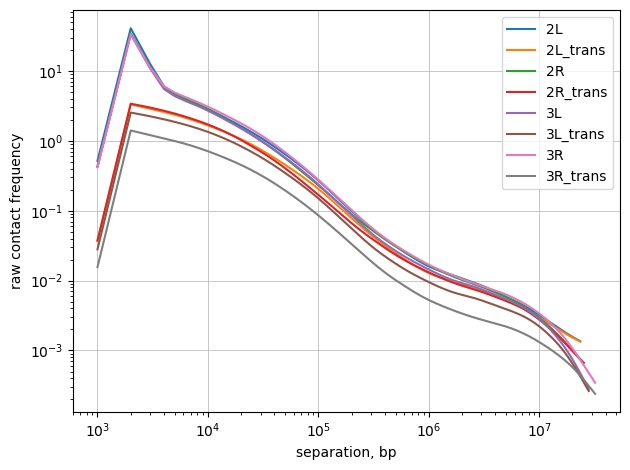

In [11]:
chromsizes_path = "/data/alhajabed/FlyHiC/PoreC/20250625_balancedMcools/dm6_genome.reduced.chromsizes.reduced"
chromsizes = pd.read_csv(chromsizes_path, sep="\t", header=None, names=["chrom", "size"])

clr = cooler.Cooler("/data/alhajabed/FlyHiC/PoreC/20250625_balancedMcools/20250729_merged_PnMs.filtCisTrans.pairs.cool")

# compute P(s) curves
cvd_smooth_agg = cooltools.expected_cis(
    clr=clr,
    view_df=None,
    smooth=True,
    aggregate_smoothed=True,
    smooth_sigma=0.1,
    nproc=2,
    clr_weight_name=None
    )

# Plot raw (unbalanced) average
fig, ax = plt.subplots(1,1)

for region in chromsizes['chrom']:
    region_data = cvd_smooth_agg[cvd_smooth_agg['region1'] == region]
    ax.loglog(
        region_data['dist_bp'],
        region_data['count.avg.smoothed'],  # ← for unbalanced data
        label=region
    )

ax.set(
    xlabel='separation, bp',
    ylabel='raw contact frequency'
)
ax.set_aspect('auto')  # relaxed aspect for better plotting
ax.grid(True, lw=0.5)
ax.legend(loc='upper right')
plt.tight_layout()

INFO:root:creating a Pool of 2 workers


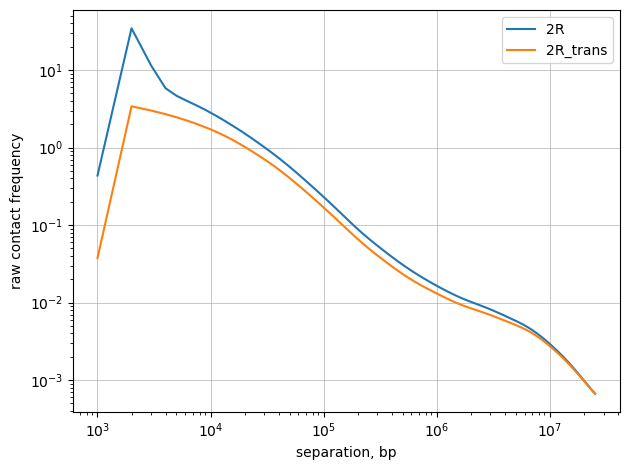

In [19]:
chromsizes_path = "/data/alhajabed/FlyHiC/PoreC/20250625_balancedMcools/dm6_genome.reduced.chromsizes.reduced"
chromsizes = pd.read_csv(chromsizes_path, sep="\t", header=None, names=["chrom", "size"])

clr = cooler.Cooler("/data/alhajabed/FlyHiC/PoreC/20250625_balancedMcools/20250729_merged_PnMs.filtCisTrans.pairs.cool")

# compute P(s) curves
cvd_smooth_agg = cooltools.expected_cis(
    clr=clr,
    view_df=None,
    smooth=True,
    aggregate_smoothed=True,
    smooth_sigma=0.1,
    nproc=2,
    clr_weight_name=None
)

# Plot raw (unbalanced) average only for 2R and 3R
fig, ax = plt.subplots(1, 1)

for region in ['2R', '2R_trans']:
    region_data = cvd_smooth_agg[cvd_smooth_agg['region1'] == region]
    ax.loglog(
        region_data['dist_bp'],
        region_data['count.avg.smoothed'],  # ← for unbalanced data
        label=region
    )

ax.set(
    xlabel='separation, bp',
    ylabel='raw contact frequency'
)
ax.set_aspect('auto')  # relaxed aspect for better plotting
ax.grid(True, lw=0.5)
ax.legend(loc='upper right')
plt.tight_layout()

INFO:root:creating a Pool of 2 workers


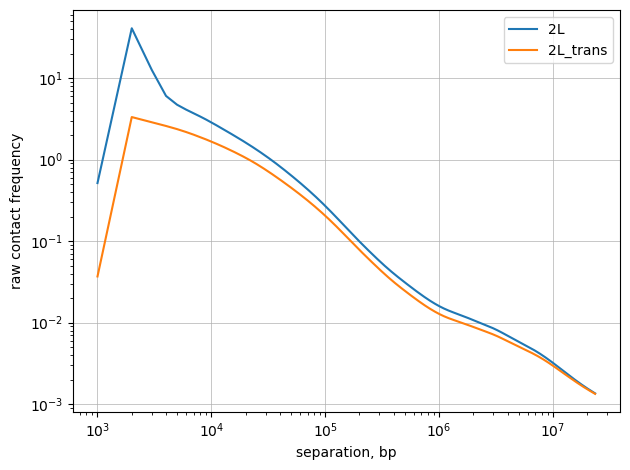

In [21]:
chromsizes_path = "/data/alhajabed/FlyHiC/PoreC/20250625_balancedMcools/dm6_genome.reduced.chromsizes.reduced"
chromsizes = pd.read_csv(chromsizes_path, sep="\t", header=None, names=["chrom", "size"])

clr = cooler.Cooler("/data/alhajabed/FlyHiC/PoreC/20250625_balancedMcools/20250729_merged_PnMs.filtCisTrans.pairs.cool")

# compute P(s) curves
cvd_smooth_agg = cooltools.expected_cis(
    clr=clr,
    view_df=None,
    smooth=True,
    aggregate_smoothed=True,
    smooth_sigma=0.1,
    nproc=2,
    clr_weight_name=None
)

# Plot raw (unbalanced) average only for 2R and 3R
fig, ax = plt.subplots(1, 1)

for region in ['2L', '2L_trans']:
    region_data = cvd_smooth_agg[cvd_smooth_agg['region1'] == region]
    ax.loglog(
        region_data['dist_bp'],
        region_data['count.avg.smoothed'],  # ← for unbalanced data
        label=region
    )

ax.set(
    xlabel='separation, bp',
    ylabel='raw contact frequency'
)
ax.set_aspect('auto')  # relaxed aspect for better plotting
ax.grid(True, lw=0.5)
ax.legend(loc='upper right')
plt.tight_layout()

INFO:root:creating a Pool of 2 workers


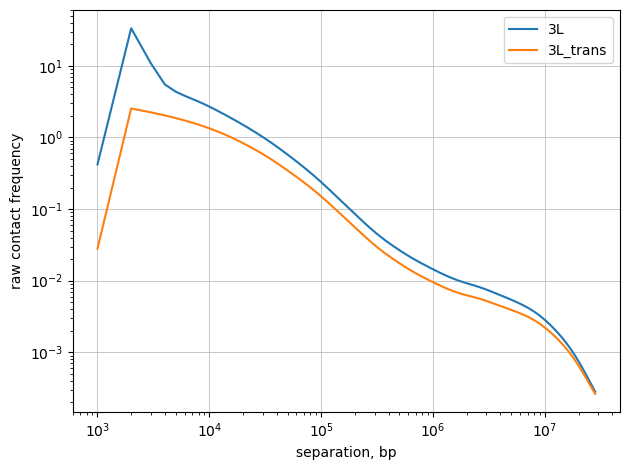

In [22]:
chromsizes_path = "/data/alhajabed/FlyHiC/PoreC/20250625_balancedMcools/dm6_genome.reduced.chromsizes.reduced"
chromsizes = pd.read_csv(chromsizes_path, sep="\t", header=None, names=["chrom", "size"])

clr = cooler.Cooler("/data/alhajabed/FlyHiC/PoreC/20250625_balancedMcools/20250729_merged_PnMs.filtCisTrans.pairs.cool")

# compute P(s) curves
cvd_smooth_agg = cooltools.expected_cis(
    clr=clr,
    view_df=None,
    smooth=True,
    aggregate_smoothed=True,
    smooth_sigma=0.1,
    nproc=2,
    clr_weight_name=None
)

# Plot raw (unbalanced) average only for 2R and 3R
fig, ax = plt.subplots(1, 1)

for region in ['3L', '3L_trans']:
    region_data = cvd_smooth_agg[cvd_smooth_agg['region1'] == region]
    ax.loglog(
        region_data['dist_bp'],
        region_data['count.avg.smoothed'],  # ← for unbalanced data
        label=region
    )

ax.set(
    xlabel='separation, bp',
    ylabel='raw contact frequency'
)
ax.set_aspect('auto')  # relaxed aspect for better plotting
ax.grid(True, lw=0.5)
ax.legend(loc='upper right')
plt.tight_layout()

INFO:root:creating a Pool of 2 workers


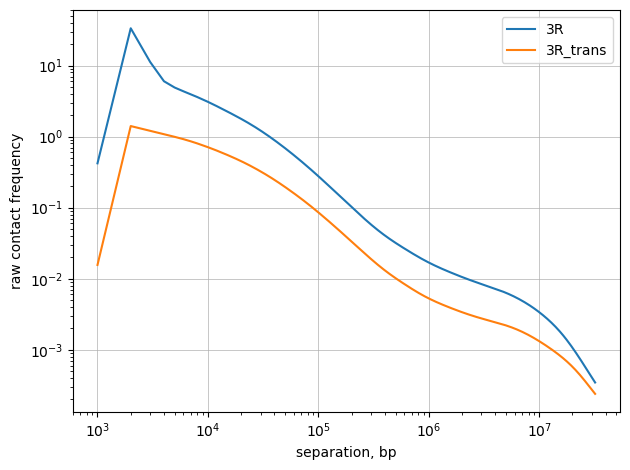

In [23]:
chromsizes_path = "/data/alhajabed/FlyHiC/PoreC/20250625_balancedMcools/dm6_genome.reduced.chromsizes.reduced"
chromsizes = pd.read_csv(chromsizes_path, sep="\t", header=None, names=["chrom", "size"])

clr = cooler.Cooler("/data/alhajabed/FlyHiC/PoreC/20250625_balancedMcools/20250729_merged_PnMs.filtCisTrans.pairs.cool")

# compute P(s) curves
cvd_smooth_agg = cooltools.expected_cis(
    clr=clr,
    view_df=None,
    smooth=True,
    aggregate_smoothed=True,
    smooth_sigma=0.1,
    nproc=2,
    clr_weight_name=None
)

# Plot raw (unbalanced) average only for 2R and 3R
fig, ax = plt.subplots(1, 1)

for region in ['3R', '3R_trans']:
    region_data = cvd_smooth_agg[cvd_smooth_agg['region1'] == region]
    ax.loglog(
        region_data['dist_bp'],
        region_data['count.avg.smoothed'],  # ← for unbalanced data
        label=region
    )

ax.set(
    xlabel='separation, bp',
    ylabel='raw contact frequency'
)
ax.set_aspect('auto')  # relaxed aspect for better plotting
ax.grid(True, lw=0.5)
ax.legend(loc='upper right')
plt.tight_layout()

Balancing

(PoreC) erikson@deep22:/data/alhajabed/FlyHiC/PoreC/20250625_balancedMcools$ cooler balance 20250727_merged_PnMs.filt.pairs.cool

(PoreC) erikson@deep22:/data/alhajabed/FlyHiC/PoreC/20250625_balancedMcools$ cooler zoomify 20250727_merged_PnMs.filt.pairs.cool -o 20250727_merged_PnMs.filt.pairs.mcool --resolutions 1000,10000,20000,40000,100000



In [ ]:
clr = cooler.Cooler("/data/alhajabed/FlyHiC/PoreC/20250625_balancedMcools/20250727_merged_PnMs.filt.pairs.cool")


mat = clr.matrix(balance=False).fetch("2R_JJg14_057")

print("Matrix stats:")
print(f"Max value: {np.max(mat)}")
print(f"Min value: {np.min(mat)}")
print(f"NaNs present: {np.isnan(mat).any()}")
print(f"Rows with all zeros: {np.sum(np.all(mat == 0, axis=1))}")
print(f"Columns with all zeros: {np.sum(np.all(mat == 0, axis=0))}")

plt.imshow(np.log1p(mat), cmap="Blues", origin="lower")
plt.title("Contact map (log1p raw counts) unbalanced")
plt.colorbar(label='log1p(count)')
plt.tight_layout()
plt.show()

mat = clr.matrix(balance=True).fetch("2R_JJg14_057")
mat = np.clip(mat, 0, np.percentile(mat, 99))  

plt.imshow(np.log1p(mat), cmap="Blues", origin="lower")
plt.title("Contact map (log1p raw counts) balanced")
plt.colorbar(label='log1p(count)')
plt.tight_layout()
plt.show()

FileNotFoundError: [Errno 2] Unable to synchronously open file (unable to open file: name = '/data/alhajabed/FlyHiC/PoreC/20250625_balancedMcools/ 20250727_merged_PnMs.filt.pairs.cool', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)